In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import seaborn as sns
import pandas as pd
import math
import random
%matplotlib inline
from scipy.optimize import curve_fit


# get all the colors
import matplotlib.colors as mcolors

In [3]:
markers = itertools.cycle(['o','s','v', '+'])
colors_ls = list(mcolors.TABLEAU_COLORS)[:30]
colors = itertools.cycle(sns.color_palette())
TWOPI = math.pi * 2
kPSep = os.sep

disorder_pbc = f"..{kPSep}results{kPSep}disorder{kPSep}PBC{kPSep}"
symm_pbc = f"C:{kPSep}Users{kPSep}maxgr{kPSep}Desktop{kPSep}Wyniken{kPSep}results2_2{kPSep}symmetries{kPSep}PBC{kPSep}"

----------------------
# String separators and helper functions

### Concatenate list to a string given a separator
--------------

In [4]:
# Function to convert  
def listToString(s, separator = ","): 
    # initialize an empty string
    str1 = ""   
    # traverse in the string  
    for ele in s: 
        if isinstance(ele, (float,int)):
            str1 += "{:.3f}".format(ele) +separator 
        else:
            str1 += str(ele) +separator  
    
    # return string  
    return str1[:-1] 

### Creating a folder given a directory
-----------

In [5]:
def createFolder(directories, silent = False):
    for folder in directories:
        try:
            if not os.path.isdir(folder):
                os.makedirs(folder)
                if not silent:
                    print("Created a directory : ", folder)
        except OSError:
            print("Creation of the directory %s failed" % folder)      
# Guard against race condition
        except OSError as exc: 
            if exc.errno != errno.EEXIST:
                raise

### Reading random number from a folder given a condition
--------------

In [6]:
dat = lambda x : x.endswith('.dat')
def readRandomFile(folder, cond, withoutFolder = False):
    choice = random.choice(os.listdir(folder))
    #print(choice)
    maxlen = len(os.listdir(folder))
    counter = 0
    while not cond(choice):
        choice = random.choice(os.listdir(folder))
        if counter > maxlen:
            raise
        counter += 1
    if withoutFolder:
        return choice
    else:
        return folder + choice

### finding things in the list that are the same not to print them twice
----------

In [7]:
def findDifferentElementsStrings(listOfStrings):
    different = []
    same = set()
    if len(listOfStrings) != 0:
        # create the intersection to distinguish same elements
        same = set(listOfStrings[0].split(","))
        for i in range(1,len(listOfStrings)):
            tmp = set(listOfStrings[i].split(","))
            same = same.intersection(tmp)
        # after having the intersection find the list of names to put into legend that are different
        for i in range(0, len(listOfStrings)):
            tmp = set(listOfStrings[i].split(",")) - same
            different.append(listToString(tmp))
    # return same and list of different strings in the form of tuple
    return (listToString(same), different)

findDifferentElementsStrings(["g=1,h=2", "g=1,h=3,w=4"])

('g=1', ['h=2', 'h=3,w=4'])

### Print to file with adjusting column width

In [8]:
def justPrinter(file,sep="\t", elements =[], width = 8, endline = True):
    for item in elements:
        file.write((str(item) + sep).ljust(width))
    if endline:
        file.write("\n")

#### return list of axes

In [9]:
def listOfAxis(num, figsize = (10,10), dpi = 100):
    fig, ax = plt.subplots(num, figsize=(10,10), dpi = 100)
    sns.set_style("ticks")
    # set axis for it to always be a list
    axis = []
    if num > 1: # if we have many columns to plot
        axis = [ax[i] for i in range(num)]
    else:
        axis = [ax]
    return fig, axis

-------------------------
# Handle all the files starting from a given name given by the user and distinguished by the parameters and return the list of dataframes

In [10]:
def check_header(filename):
    with open(filename) as f:
        first = f.read(1)
        return first not in '.-0123456789'

### Fit functions
---------

In [11]:
def poisson_fit(x, lambd):
    return lambd * np.exp(-lambd * np.abs(x))
    
def laplace_fit(x, lambd,mu):
    return np.exp(-np.abs(x - mu)/lambd)/(2*lambd)

def exponential_fit(x, lambd,sigma):
    return sigma * np.exp(-lambd * np.abs(x))

def gauss_fit(x, mu, sigma):
    return np.exp(-0.5*np.power(x-mu,2)/(sigma*sigma))/(sigma*math.sqrt(2*np.pi))

def linear_fit(x,a,b):
    return a*x+b

fitDic = {
    poisson_fit : ('poisson','$\lambda$*exp(-$\lambda$x):' ,'$\lambda$='),
    laplace_fit : ('laplace','exp(-|x-$\mu$|/$\lambda$)/2$\lambda$:',"$\mu$=",'$\lambda$='),
    exponential_fit : ('exponential','$\sigma$*exp(-$\lambda$x):', '$\sigma$=', '$\lambda$=' ),
    gauss_fit : ('gaussian','exp(-$(x-\mu)^2$/2($\sigma^2$))/($\sigma$*$\sqrt{2\pi}$):', '$\mu$=', '$\sigma$=' ),
    linear_fit : ('linear', 'a*x+b:', 'a=', 'b=')
}
fitDic

{<function __main__.poisson_fit(x, lambd)>: ('poisson',
  '$\\lambda$*exp(-$\\lambda$x):',
  '$\\lambda$='),
 <function __main__.laplace_fit(x, lambd, mu)>: ('laplace',
  'exp(-|x-$\\mu$|/$\\lambda$)/2$\\lambda$:',
  '$\\mu$=',
  '$\\lambda$='),
 <function __main__.exponential_fit(x, lambd, sigma)>: ('exponential',
  '$\\sigma$*exp(-$\\lambda$x):',
  '$\\sigma$=',
  '$\\lambda$='),
 <function __main__.gauss_fit(x, mu, sigma)>: ('gaussian',
  'exp(-$(x-\\mu)^2$/2($\\sigma^2$))/($\\sigma$*$\\sqrt{2\\pi}$):',
  '$\\mu$=',
  '$\\sigma$='),
 <function __main__.linear_fit(x, a, b)>: ('linear', 'a*x+b:', 'a=', 'b=')}

##### distinguish between different fits and append it to the legend list

In [12]:
def addFitFunction(fitFun, appendList, popt):
    tmp = fitDic[fitFun]
    fitname = tmp[0] + ',' + tmp[1]
    counter = 0
    for param in tmp[2:]:
        appendList.append(f'{param}' + "{:.3f}".format(popt[counter]))
        counter += 1
    return fitname

##### fit to dataframe from dataframe

In [13]:
def fitToDataframe(fitFun, x, y):
    # fit curve
    xdata = np.array(x)
    ydata = np.array(y)
    popt, pcov = curve_fit(fitFun, x, ydata)
    return popt, pd.DataFrame(fitFun(x, *popt))

-----------
### Give dataframes from files

In [14]:
def handle_all_files(directory, file_begin, columns, distinguishers, separator = "\t\t", fitfunctions = []):
    # columns is a list of tuples of column number and its name [(0:...)] etc -> 0 is an idx
    dfs = []
    # make fit before
       
    
    for filename in os.listdir(directory):
        if filename[-4:] != ".dat" or not filename.startswith(file_begin):
            continue
        # split the name and the parameters
        splitter = filename[:-4].split("_")
        # split each of the parameters 
        params = splitter[-1].split(",")
        skip = False
        
        for element in distinguishers:
            in_bucket = False
            # check elements in each element_bucket
            for bucket in element:
                if bucket in params:
                    in_bucket = True
            # if none of possible parameters from individual bucket is in params => skip
            if not in_bucket:
                skip = True
                break
                
        if not skip or len(distinguishers) == 0:
            skip_rows = 0
            # check if there is a header present already
            if check_header(directory + filename):
                skip_rows = 1
            tmp = pd.read_csv(directory + filename, sep = separator, header=None, skiprows = skip_rows, index_col = 0)

            # check if nan's are in and skip that column if all are nans
            tmp = tmp.loc[:,tmp.notna().all(axis=0)]
            # if there is still something to read then read!
            if len(columns) > 0:
                names = [column[0] for column in columns]
                numbers = [column[1] for column in columns]
                
                # take everything except the index
                tmp = tmp[numbers[1:]]
                tmp.columns = names[1:]
            # append new df to a list of dataframes with its params   
            dfs.append((tmp, listToString(params)))
            for fitFun in fitfunctions:
                # always take the first column for the fit
                popt, fit_df = fitToDataframe(fitFun, tmp.index, tmp[columns[1][0]])
                fit_df.index = tmp.index
                # add labels
                params_fit = []
                fitname = addFitFunction(fitFun, params_fit,popt)
                # append to dataframes
                dfs.append((fit_df, f'{fitname+listToString(params_fit,separator=":")},{listToString(params,separator=",")}'))    
    #print(dfs)
    return dfs

tmp = handle_all_files(symm_pbc, "IprScaling", columns = [("h",0), ("ipr",1), ("$r_{goe}$",3)], distinguishers = [["g=0.80"]], fitfunctions = [linear_fit])
tmp

[]

# Operators plotter as a function of energies, plots all elements connecting files with parameters present in the distinguisher

In [15]:
def plot_av_operator_dfs(directory, file_begin, columns, distinguishers, operator_name,\
                         scale_x = "linear", scale_y = "linear",\
                         separator = "\t\t", fitfunctions = [],\
                         xmin = -0.05, xmax = 0.05, ymin = 0.01, ymax = 100):
    # clean plot    
    plt.clf()
    plt.cla()
    
    fitter = []
    for fitFun in fitfunctions:
        fitter.append(fitDic[fitFun][0])
        
    # save in folder
    folder = f'{directory}plots{kPSep}' 
    createFolder([folder])
    #print(directory)
    # find the list of dataframes
    a = handle_all_files(directory, file_begin, columns, distinguishers, separator = separator, fitfunctions = fitfunctions)
    if len(a) == 0:
        return
    else:
        #unpack
        listOfDf = [item[0] for item in a]
        labels = [item[1] for item in a]
        
    print(labels)
    # create number of figures to be plotted
    fig, axis = listOfAxis(len(columns) - 1, figsize=(10,10), dpi = 100)

    # for files
    same_and_diff = findDifferentElementsStrings(labels)
    savefile = file_begin + "_" + same_and_diff[0]
    
    # plot
    colorki = [next(colors) for i in range(len(listOfDf))]
    markerki = [next(markers) for i in range(len(listOfDf))]
    
    # iterate over dataframes
    df_iter = 0
    for df in listOfDf:
        itr = 0
        for col in df.columns:
            df[col].plot(ax = axis[itr]
                    , linewidth=0.5
                    , marker=markerki[df_iter]
                    , markersize=1.8
                    , color = colorki[df_iter])
            itr+=1
        df_iter += 1

    # set the style
    for i in range(len(columns) - 1):
        axis[i].set(xlabel = columns[0][0],
                ylabel = columns[i+1][0])
        axis[i].set_yscale(scale_y)
        axis[i].set_xscale(scale_x)
        
        if(len(listOfDf) > 1):
            axis[i].legend(same_and_diff[1] 
                    , frameon=False
                    , loc='best'
                    , fontsize=8.5)
            
        if xmin != None and xmax != None:
            axis[i].set_xlim([xmin,xmax])
        if ymin != None and ymax != None:
            axis[i].set_ylim([ymin, ymax])
    
    # add title
    fig.suptitle(operator_name + " for " + same_and_diff[0], y=0.91)
    # set fitfunctions
    fits = ".png"
    if(len(fitfunctions) > 0):
        fits = f',{listToString(fitter,",")}{fits}'
        #print(fits)
    plt.savefig(f'{folder + savefile},scale_y={scale_y},scale_x={scale_x }{fits}')
    plt.show()

D:\Programy\MyAnacondaDont\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


['L=18,g=0.80,h=1.15,k=0,p=1,x=1,pert=0.0037', 'laplace,exp(-|x-$\\mu$|/$\\lambda$)/2$\\lambda$:$\\mu$=0.005:$\\lambda$=-0.002,L=18,g=0.80,h=1.15,k=0,p=1,x=1,pert=0.0037', 'gaussian,exp(-$(x-\\mu)^2$/2($\\sigma^2$))/($\\sigma$*$\\sqrt{2\\pi}$):$\\mu$=-0.002:$\\sigma$=0.005,L=18,g=0.80,h=1.15,k=0,p=1,x=1,pert=0.0037']


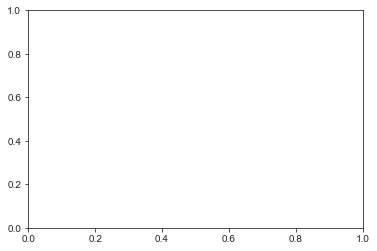

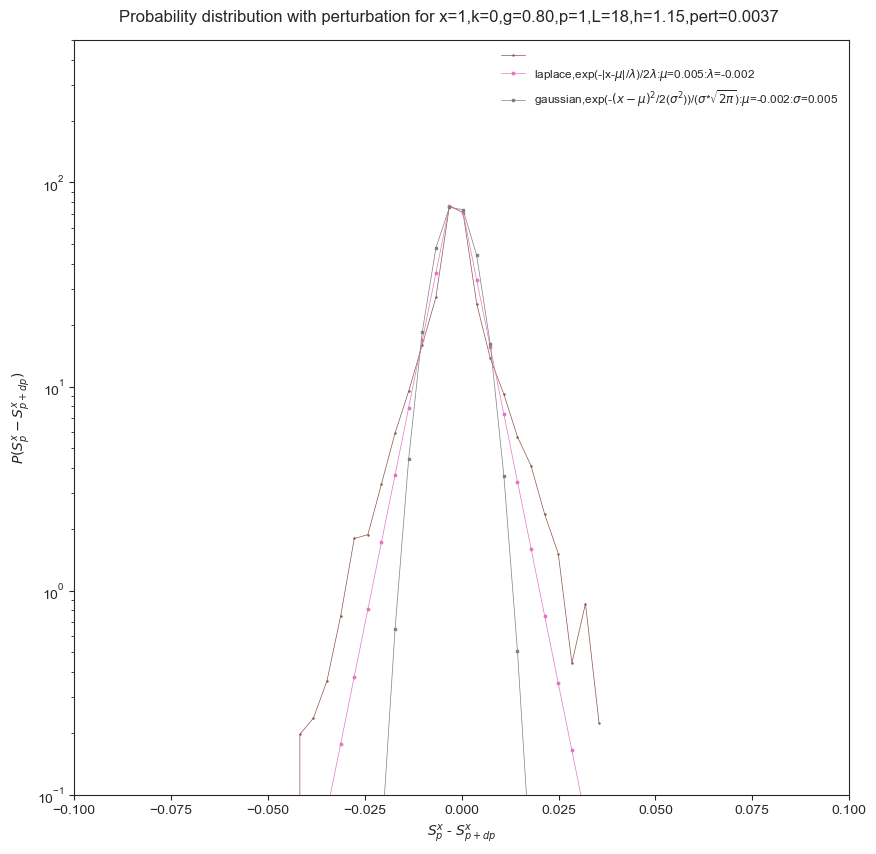

In [21]:
# sigma_x                    
#plot_av_operator_dfs(symm_pbc, "SigmaX",columns = [("E/L",0), ("<n|$S_x$|n>",1)], distinguishers = [], operator_name = "<n|$S_x$|n>") 
# sigma_x prob dist
#plot_av_operator_dfs(symm_pbc, "ProbDistSigmaX",columns = [("$S^x_{nn}$", 0), ("P($S^x_{nn}$)",1)], distinguishers = [["L=18"],["g=0.80"], ["h=1.00","h=1.50"]],
#                      operator_name = "Probability distribution of $S^x_{nn}$", scale_y = 'log', fitfunctions = []) 
# sigma x repulsion
#plot_av_operator_dfs(symm_pbc, "ProbDistSpecRapSigmaX",columns = [("$S^x_{nn} - $S^x_{n-1,n-1}$", 0), ("P(r)",1)],
 #distinguishers = [["L=19","L=18", "L=17", "L=16"],["g=0.8"], ["h=1.00"]], operator_name = "("$S^x_{nn} - $S^x_{n-1,n-1}$", 0), ("P(r)",1)", scale_y = 'linear', separator = '\t')
# sigma x prob dist all sectors
#plot_av_operator_dfs(symm_pbc, "ProbDistSpecRapSigmaXAllSectors",columns = [("$S^x_{nn} - $S^x_{n-1,n-1}$", 0), ("P(r)",1)],
 #distinguishers = [], operator_name = "P(r) for all sectors", scale_y = 'linear', separator = '\t\t') 

# energy difference
#plot_av_operator_dfs(symm_pbc + "/EnergyDiff/", "perturbationEnergyDiffDist",columns = [("E-E'", 0), ("P(E-E')",1)], 
#                     distinguishers = [["L=18"],["g=0.80"], ["h=1.80"], ["pert=0.0100", "pert=0.0300", "pert=0.1100", "pert=0.1500"]],
#                     operator_name = "P(E-E')", scale_y = 'log', fitfunctions =[], xmin = -0.25, xmax = 0.25) 
# operators dist
plot_av_operator_dfs(symm_pbc, "perturbationOperatorsDist",columns = [("$S^x_p$ - $S^x_{p+dp}$", 0), ("$P(S^x_p-S^x_{p+dp})$", 1)],
                    distinguishers = [["L=18"],["g=0.80"], ["h=1.15"], ["pert=0.0037"]],
                    operator_name = "Probability distribution with perturbation", scale_y ="log",\
                     fitfunctions=[laplace_fit, gauss_fit],\
                     xmin = -0.1, xmax = 0.1, ymin = 0.1, ymax = 500) 

#ipr scaling with h
#plot_av_operator_dfs(symm_pbc, "IprScaling",columns = [("h", 0), ("ipr", 1), ("Information entropy", 2), ("$r_{goe}$",3)], distinguishers = [["L=18"],["g=1.20","g=0.80", "g=0.40"]], operator_name = "System scaling with h")
# moments of probability sigma_x fluct
#plot_av_operator_dfs(symm_pbc, "Moments",columns = [("h", 0), ("$U_B$", 1), ("Kurtossis", 2), ("$\sigma$",3)], distinguishers = [["L=18"],["g=1.20","g=0.80"]], operator_name = "System scaling with h")

## Plot only distributions in different files

In [6]:
def plot_distribution(directory, file_begin, columns, distinguishers, distribution_name, column_num = [], separator = "\t\t"):
    try:
        folder = 'plots/' + directory 
        if not os.path.isdir(folder):
            os.makedirs(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        # find the list of dataframes
        listOfDf = handle_all_files(directory, file_begin,columns, distinguishers, column_num, separator)
        labels = [item[1] for item in listOfDf]
        same_and_diff = findDifferentElementsStrings(labels)
        
        # plot 
        counter = 0
        for df in listOfDf:
            savefile = file_begin + "_" + same_and_diff[0] + "," + labels[counter]
            fig, ax = plt.subplots(len(columns) - 1, figsize=(12,8), dpi = 120) 
            axis = []
            if len(columns) > 2: # if we have many columns to plot
                axis = [ax[i] for i in range(len(columns) - 1)]
            else:
                axis = [ax]
            
            step = 0.01
            _min = np.min(df[0].index)
            _max = np.max(df[0].index)
            new_ticks = [_min + step * i for i in range(0, int((_max-_min)/step) + 1)]
            print(new_ticks)
            itr = 0
            for col in df[0].columns:      

                df[0][col].plot.bar(ax = axis[itr], rot=15, color = next(colors))
                axis[itr].set(title = distribution_name + " for " + same_and_diff[0] + "," + same_and_diff[1][counter]
                            ,xlabel = col
                            ,ylabel = distribution_name)
                #axis[itr].get_legend().remove()
                #(same_and_diff
                #            , frameon=False
                #            , loc='best'
                #            , fontsize=8)
                axis[itr].set_xticks(np.interp(new_ticks, df[0].index, np.arange(df[0].size)))
                axis[itr].set_xticklabels(new_ticks)
                itr+=1
            counter+=1
            plt.savefig(folder + savefile + ".pdf")
            plt.savefig(folder + savefile + ".png")
            plt.show()


#plot_distribution(symm_pbc, "ProbDistSpecRapSigmaX", columns = ["P(|r|)", "<n + 1|$S_x$|n + 1> - <n|$S_x$|n>"], distinguishers = [], distribution_name= "P(|r|)", separator = "\t")

# PLOT HEATMAP

<ipython-input-8-1fe9dfbc6c59>:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(directory + filename, sep = separator, header=None,skiprows = skip_rows, index_col = 0)


0.308087 0.30844


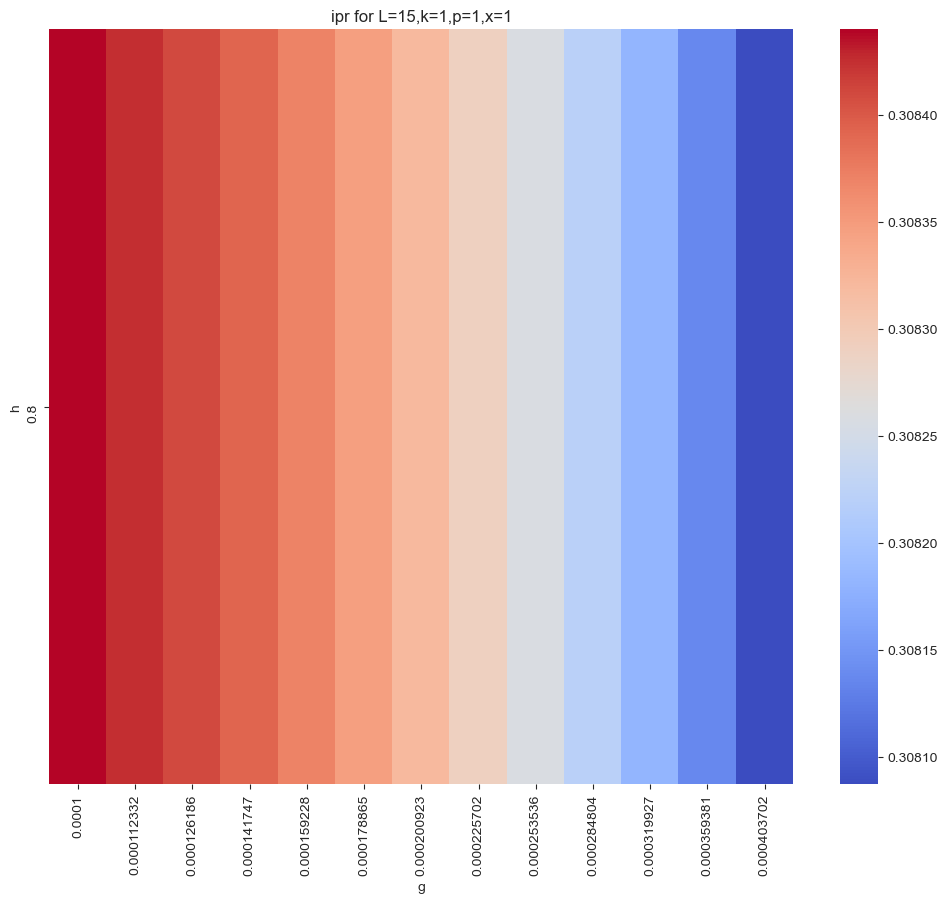

In [11]:
def plot_heat_map(directory, file_begin, columns, distinguishers, operator_name, separator = "\t\t"):
    try:
        folder = 'plots/' + directory 
        if not os.path.isdir(folder):
            os.makedirs(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        
        # find the list of dataframes
        listOfDf = handle_all_files(directory, file_begin,columns, distinguishers, separator)
        labels = [item[1] for item in listOfDf]
        same_and_diff = findDifferentElementsStrings(labels)
            
        # plot 
        counter = 0
        for df in listOfDf:
            fig, ax = plt.subplots(figsize=(12,10), dpi = 100)
            savefile = operator_name + "_" + same_and_diff[0] + "," + labels[counter]
            df[0]["index"] = df[0].index
            cols = df[0].columns
            #print(cols)
            pivotted = df[0].pivot(cols[2], cols[0], cols[1])
            # PLOT 
            z = np.array(df[0].loc[:,cols[1]])
            y = np.array(df[0].loc[:,cols[0]])
            x = np.array(df[0].loc[:,cols[2]])
            #print(z)
            mini = np.min(z)
            maxi = np.max(z)
            print(mini,maxi)
            sns.heatmap(pivotted,cmap='coolwarm',vmin=np.min(z), vmax=np.max(z))
            #sns.heatmap(pivotted,cmap='coolwarm',vmin=np.min(z), vmax=np.max(z))
            if(len(columns) == 3):
                plt.xlabel(columns[0][0])
                plt.ylabel(columns[1][0])
            #ax.set_zscale([0.35,0.535])
            plt.title(operator_name + " for " + labels[counter])
            plt.savefig(folder + savefile + ".png")
            plt.savefig(folder + savefile + ".pdf")
            plt.show()
            counter +=1
    
                  


# ipr parameter sweeep
plot_heat_map(symm_pbc, "IprScalingMap",columns = [("g",0), ("h",1),("ipr",2)], distinguishers = [["L=15"]], operator_name = "ipr") 

NameError: name 'filesToDataFrame' is not defined

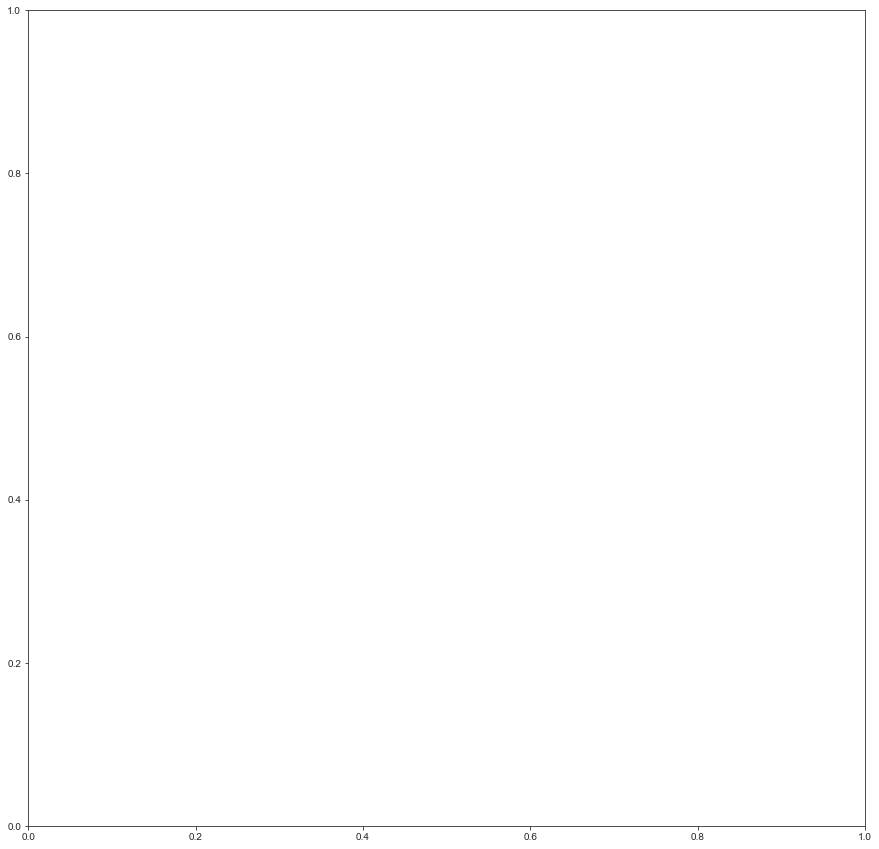

In [68]:
def plotKurtosisFromDF(directory,name_of_file_start, x_distinguisher, Ls):
    
    fig, ax = plt.subplots(figsize=(15,15))
    labels = []
    for L in Ls:
        pd = filesToDataFrame(directory, name_of_file_start, L, x_distinguisher)
        values = []
        kurto = []
        if not pd.empty:
            labels.append("L=" + str(L))
                     
            kurtos = pd.kurtosis(axis = 0)
            #print(kurtos)
            kurto = [a for a in kurtos]
            values = [float(x.split("=")[-1]) for x in kurtos.index]                 # list of possible x_disting values
            #print(kurto)
            #print(values)
            # print(len(kurto))
            # print(len(values))
            order = np.argsort(values)
            
            
            ax.plot(np.array(values)[order], np.array(kurto)[order],
                    linewidth = 1.5,
                    marker = next(markers),
                    markersize = 4
                )
    #print(labels)       
    ax.set(title = "kurtosis of $\sigma _x$ probability distribution"
    , xlabel = x_distinguisher
    , ylabel = "kurtosis(P($\sigma _x$))")
    ax.legend(labels
      , frameon=False
      , loc='best'
      , fontsize=8)
    ax.set_xlim([0,4.5])
    #ax.set_ylim([0,4])
    plt.savefig(directory + "kurtosis_" + name_of_file_start + ".png")
    plt.show()

plotKurtosisFromDF(disorder_pbc, "ProbDistSigmaX", "w", ["10", "12"])

NameError: name 'filesToDataFrame' is not defined

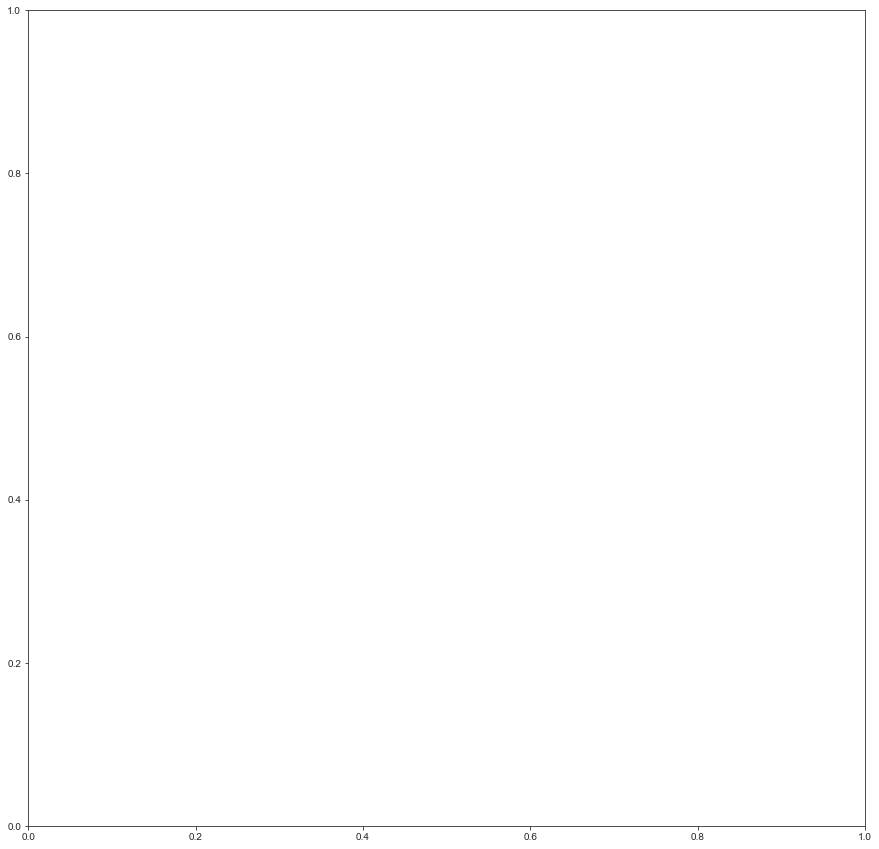

In [60]:
def plotBinderFromDF(directory,name_of_file_start, x_distinguisher, Ls):
    
    fig, ax = plt.subplots(figsize=(15,15))
    labels = []
    for L in Ls:
        pd = filesToDataFrame(directory, name_of_file_start, L, x_distinguisher)
        values = []
        binder = []
        if not pd.empty:
            labels.append("L=" + str(L))
            
            square_pd = pd.apply(np.square, axis =1)
            fourth_pd=square_pd.apply(np.square, axis = 1)
            
            #print(square_pd)
            
            fourth_mean = [fourth_pd[a].mean() for a in fourth_pd.columns]
            square_mean = [square_pd[a].mean() for a in square_pd.columns]

            
            for i in range(len(square_mean)):
                binder.append(1 - fourth_mean[i]/(3*square_mean[i]))
            ##print(binder)
            values = [float(x.split("=")[-1]) for x in pd.columns]                 # list of possible x_disting values
            
            order = np.argsort(values)
            #print(kurto)
            #print(values)
            # print(len(kurto))
            # print(len(values))
            ax.plot(np.array(values)[order], np.array(binder)[order],
                    linewidth = 1.5,
                    marker = next(markers),
                    markersize = 4
            )
    #print(labels)       
    ax.set(title = "Binder cumulant of $\sigma _x$ probability distribution"
    , xlabel = x_distinguisher
    , ylabel = "U(P($\sigma _x$))")
    ax.legend(labels
      , frameon=False
      , loc='best'
      , fontsize=8)
    ax.set_xlim([-0,4.5])
    #ax.set_ylim([-80,10])
    plt.savefig(directory + "BinderCumulant_" + name_of_file_start + ".png")
    plt.show()

plotBinderFromDF(disorder_pbc, "ProbDistSigmaX", "w", [12])

<ipython-input-4-1fe9dfbc6c59>:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(directory + filename, sep = separator, header=None,skiprows = skip_rows, index_col = 0)


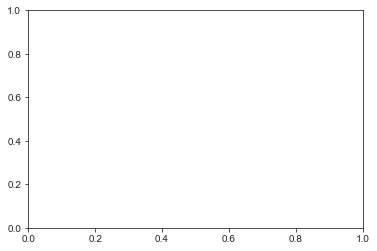

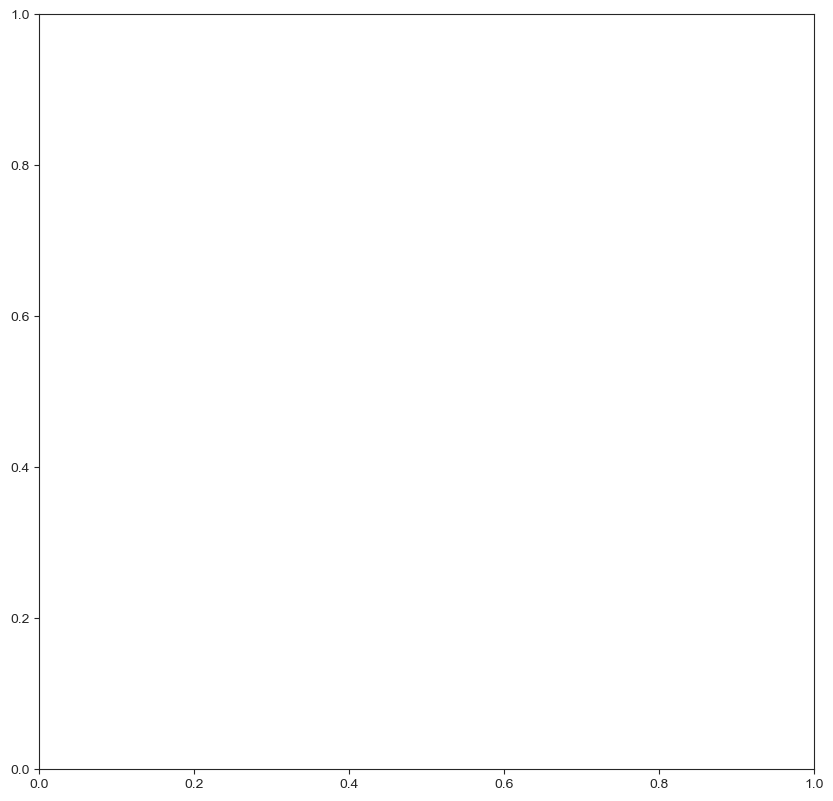

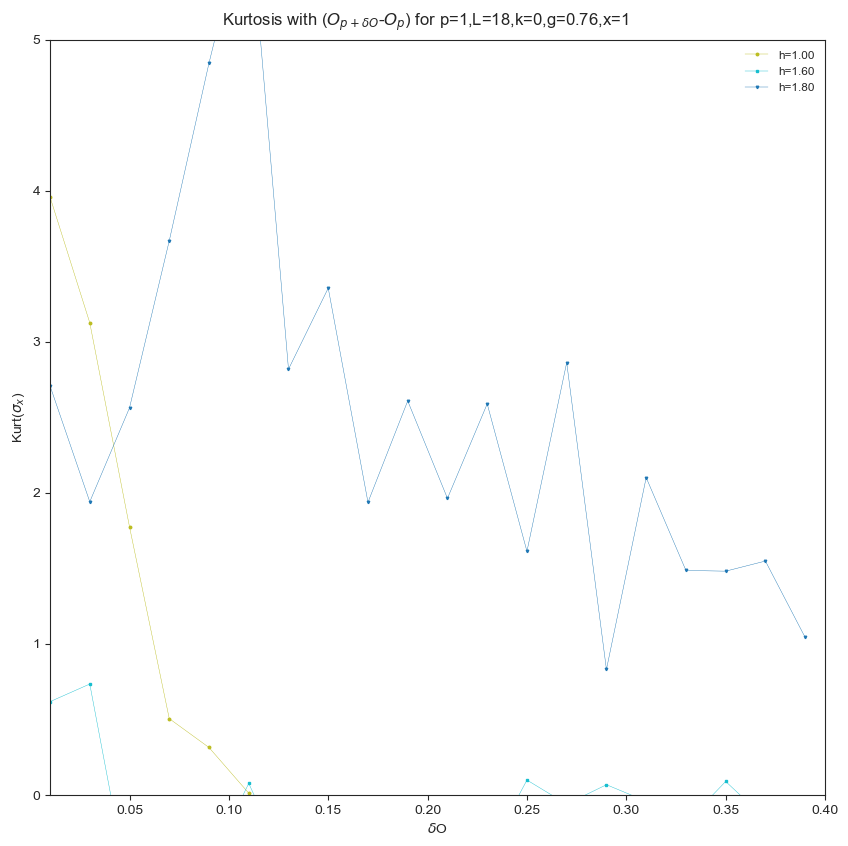

In [57]:

#gaussianity
plot_av_operator_dfs(symm_pbc, "PertKurtosis",columns = [("$\delta$O", 0),("Kurt(E)", 1), ("Kurt($\sigma_x$)", 2)],
                     distinguishers = [["L=18"],["g=0.8"], ["h=1.00", "h=1.60", "h=1.80"]],
                     operator_name = "Kurtosis with ($O_{p+\delta O}$-$O_p$)", scale_y ="linear", fitfunctions=[], ymin=0, ymax=5, xmin=0.01, xmax=0.4) 